# Predicción de notas finales con PySpark

En este análisis queremos predecir la **nota final (G3)** de los estudiantes utilizando variables socio-académicas del dataset `oot`. El flujo de trabajo se organiza en un **pipeline** para mayor claridad.

In [1]:
# Import SparkSession
from pyspark.sql import SparkSession
# usa solo 1 hilo local en mi proceso
# Create SparkSession 
spark = SparkSession.builder \
      .master("local[1]") \
      .appName("RDD") \
      .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/18 23:47:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [61]:
df.printSchema()


root
 |-- school: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- famsize: string (nullable = true)
 |-- Pstatus: string (nullable = true)
 |-- Medu: integer (nullable = true)
 |-- Fedu: integer (nullable = true)
 |-- Mjob: string (nullable = true)
 |-- Fjob: string (nullable = true)
 |-- reason: string (nullable = true)
 |-- guardian: string (nullable = true)
 |-- traveltime: integer (nullable = true)
 |-- studytime: integer (nullable = true)
 |-- failures: integer (nullable = true)
 |-- schoolsup: string (nullable = true)
 |-- famsup: string (nullable = true)
 |-- paid: string (nullable = true)
 |-- activities: string (nullable = true)
 |-- nursery: string (nullable = true)
 |-- higher: string (nullable = true)
 |-- internet: string (nullable = true)
 |-- romantic: string (nullable = true)
 |-- famrel: integer (nullable = true)
 |-- freetime: integer (nullable = true)
 |-- goout: integer (null

In [5]:
# Suponiendo que tienes un archivo CSV
df = spark.read.csv("/user/app/source/student-mat.csv", sep =";", header=True, inferSchema=True)
df.show(5)

25/09/18 23:54:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+---+---+-------+-------+-------+----+----+-------+--------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|school|sex|age|address|famsize|Pstatus|Medu|Fedu|   Mjob|    Fjob|reason|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|higher|internet|romantic|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|
+------+---+---+-------+-------+-------+----+----+-------+--------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|    GP|  F| 18|      U|    GT3|      A|   4|   4|at_home| teacher|course|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|   yes|      no|      no|     4|       3|    4|   1|   1|     3|       6|  5|  6|  6|
|    GP|  F| 17|      U|    GT3|      T|

## 1. Selección de variables
Elegimos características numéricas que pueden influir en el rendimiento académico. La variable **objetivo** será `G3` (nota final).

In [120]:
features = [ "G1", "G2"]
#Adicion de librerias
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol="features")

In [107]:
# Librerías
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, ChiSqSelector
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Definir features (como ya lo tienes)
features = ["age", "Medu", "Fedu", "traveltime", "studytime", 
            "failures", "famrel", "freetime", "goout", 
            "Dalc", "Walc", "health", "absences", "G1", "G2"]

# Ensamblar vector de features
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(df)

# Dividir en train y test
train, test = data.randomSplit([0.7, 0.3], seed=42)

# Modelo RandomForest para ver importancia de variables
rf = RandomForestClassifier(featuresCol="features", labelCol="G3", numTrees=50)
rf_model = rf.fit(train)

# Importancia de variables
importances = rf_model.featureImportances
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

# Selección automática de features con ChiSqSelector
selector = ChiSqSelector(numTopFeatures=8, featuresCol="features", 
                         outputCol="selectedFeatures", labelCol="G3")
selected = selector.fit(train)

print("Variables seleccionadas automáticamente:")
print([features[i] for i in selected.selectedFeatures])

age: 0.0479
Medu: 0.0332
Fedu: 0.0274
traveltime: 0.0171
studytime: 0.0235
failures: 0.0258
famrel: 0.0262
freetime: 0.0216
goout: 0.0298
Dalc: 0.0234
Walc: 0.0429
health: 0.0337
absences: 0.1199
G1: 0.1772
G2: 0.3503
Variables seleccionadas automáticamente:
['age', 'Medu', 'failures', 'Dalc', 'Walc', 'absences', 'G1', 'G2']


In [121]:
!pip install numpy


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [119]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as p

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df)
corr_matrix = Correlation.corr(df_vector, "features").head()[0]
corr_np = np.array(corr_matrix.toArray())
plt.figure(figsize=(12,10))
sns.heatmap(corr_np, annot=True, xticklabels=numeric_cols, yticklabels=numeric_cols, cmap="coolwarm")
plt.title("Mapa de calor de correlación - Student Math Kaggle")
plt.show()
numeric_cols = ["age","Medu","Fedu","traveltime","studytime","failures",
                "famrel","freetime","goout","Dalc","Walc","health",
                "absences","G1","G2","G3"]

ModuleNotFoundError: No module named 'seaborn'

## 2. Definir el modelo
Usaremos una **Regresión Lineal**, simple e interpretable.

In [122]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="G3")

## 3. Construcción del Pipeline
El pipeline asegura que los pasos se ejecuten en orden:
1. Ensamblar las variables en un vector.
2. Entrenar el modelo.

In [123]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[assembler, lr])

## 4. División de datos
Separamos los datos en **80% entrenamiento** y **20% prueba**.

In [124]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

## 5. Entrenamiento del modelo

In [125]:
model = pipeline.fit(train_data)

25/09/19 01:26:23 WARN Instrumentation: [02e2bd2b] regParam is zero, which might cause numerical instability and overfitting.


## 6. Predicciones y evaluación
Evaluamos el modelo con métricas de regresión:
- **RMSE**: error promedio de las predicciones. CUando se acerca a 0 es perfecto

                          0 → perfecto: todas las predicciones coinciden con los valores reales.
  
- **R²**: proporción de variabilidad explicada por el modelo.

                          1 → perfecto: el modelo explica toda la variación de las notas
                          0 → modelo no explica nada: predice tan mal como la media de G3.
                          Negativo → peor que usar la media.

                          En datasets reales con muchos factores externos, un R² entre 0.5 y 0.8 puede ser bastante bueno para un modelo simple como regresión lineal.

In [126]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol="G3", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="G3", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f" RMSE: {rmse:.2f}")
print(f" R²: {r2:.2f}")

 RMSE: 2.20
 R²: 0.78


## 7. Visualización de resultados
Mostramos un gráfico comparando las **notas reales** con las **predichas**. La línea roja indica la predicción perfecta (real = predicción).

In [30]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 36.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 43.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 37.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 11.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127891 (\N{GRADUATION CAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


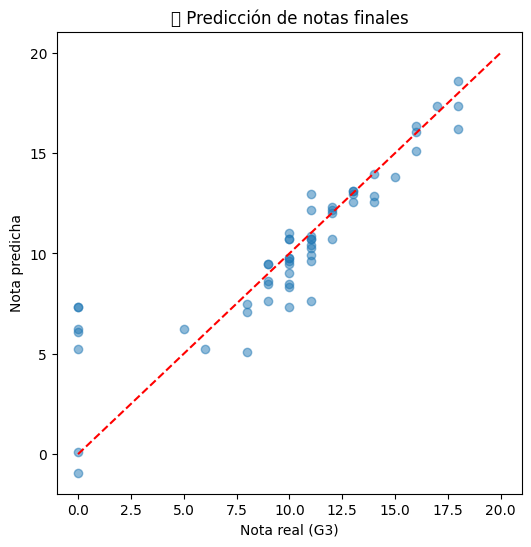

In [127]:
# Recolectar solo las columnas necesarias en una lista de tuplas
data = predictions.select("G3", "prediction").rdd.map(lambda row: (row["G3"], row["prediction"])).collect()

# Separar en listas para graficar
y_real = [d[0] for d in data]
y_pred = [d[1] for d in data]

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_real, y_pred, alpha=0.5)
plt.plot([0,20], [0,20], color="red", linestyle="--")
plt.xlabel("Nota real (G3)")
plt.ylabel("Nota predicha")
plt.title("🎓 Predicción de notas finales")
plt.show()

# Crear un DataFrame con el nuevo registro

Supongamos que tu modelo usa estas variables como features:

In [128]:
features = [ "G1", "G2"]


Y quieres predecir para un estudiante:

In [35]:
nuevo_estudiante = [(15, 14)]

Creamos un DataFrame de Spark:

In [36]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType

schema = StructType([
      StructField("G1", IntegerType(), True),
    StructField("G2", IntegerType(), True),
])

nuevo_df = spark.createDataFrame(nuevo_estudiante, schema)

In [37]:
prediccion_nueva = model.transform(nuevo_df)
prediccion_nueva.select("prediction").show()

+------------------+
|        prediction|
+------------------+
|14.025821997234022|
+------------------+



#  Tarea: Explorando el modelo de predicción

Ahora que ya vimos un pipeline básico de predicción de la nota final **G3**, vamos a realizar un ejercicio práctico.

## Instrucciones:
1. Escoge un subconjunto diferente de variables predictoras.
2. Entrena nuevamente el modelo.
3. Evalúa el **Error Cuadrático Medio (RMSE)**.
4. Compara con el modelo original:
   - ¿Mejoró o empeoró la predicción?
   - ¿Qué variables parecen más relevantes?

## Reflexión
- ¿El RMSE fue mayor o menor al modelo original?
- ¿Qué conclusiones puedes sacar sobre la importancia de las variables seleccionadas?
- ¿Qué combinación de variables recomendarías usar en el modelo final?

In [47]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("StudentPredictionStreaming") \
    .config("spark.jars", "/opt/spark/jars/spark-sql-kafka-0-10_2.11-2.4.0.jar,/opt/spark/jars/kafka-clients-2.0.0.jar") \
    .getOrCreate()

In [48]:
df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "172.27.1.51:9092") \
    .option("subscribe", "student-mat") \
    .load()

df.printSchema()

AnalysisException: Failed to find data source: kafka. Please deploy the application as per the deployment section of Structured Streaming + Kafka Integration Guide.

In [45]:
from pyspark.sql.types import StructType, StructField, IntegerType

schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("Medu", IntegerType(), True),
    StructField("Fedu", IntegerType(), True),
    StructField("traveltime", IntegerType(), True),
    StructField("studytime", IntegerType(), True),
    StructField("failures", IntegerType(), True),
    StructField("famrel", IntegerType(), True),
    StructField("freetime", IntegerType(), True),
    StructField("goout", IntegerType(), True),
    StructField("Dalc", IntegerType(), True),
    StructField("Walc", IntegerType(), True),
    StructField("health", IntegerType(), True),
    StructField("absences", IntegerType(), True),
    StructField("G1", IntegerType(), True),
    StructField("G2", IntegerType(), True)
])

In [46]:
from pyspark.sql.functions import from_json, col

raw_stream = spark.readStream.format("kafka") \
    .option("kafka.bootstrap.servers", "172.27.1.51:9092") \
    .option("subscribe", "student-mat") \
    .load()

json_stream = raw_stream.selectExpr("CAST(value AS STRING) as json_value") \
    .select(from_json(col("json_value"), schema).alias("data")) \
    .select("data.*")


AnalysisException: Failed to find data source: kafka. Please deploy the application as per the deployment section of Structured Streaming + Kafka Integration Guide.